# Fine tuning test
Test the possibility to manually annotated a few frames of the experiment, then fine tune the network on them to predict the rest of the frames.  
This is kind of overfitting part of the test set to perform well on the rest, or domain adaptation.

In [2]:
%matplotlib inline

import os, sys, time, shutil, copy, time
import random
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, external, measure, morphology
from scipy import ndimage as ndi
import cv2
import imgaug.augmenters as iaa

import torch

from utils_common.image import imread_to_float, to_npint, overlay_preds_targets
from utils_common.metrics import dice_coef
from utils_data import normalize_range, get_all_dataloaders, pad_transform, pad_transform_stack, compute_weights
from utils_finetuning import fine_tune, ROIAnnotator_mpl
from utils_loss import get_BCEWithLogits_loss
from utils_metric import get_dice_metric
from utils_model import CustomUNet, load_model
from utils_test import predict, predict_stack, evaluate, evaluate_stack

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [10]:
batch_size = 16
learning_rate = 0.0005

# Choose wether or not use synth, aug, and weights for fine tuning
synth_data = False
synth_ratio = None # ratio of synthetic data vs. real data
only_synth = False # If True, will use only the synthetic data (and all of it, at the opposite of ratio=1)
data_aug = False # If True, will use data augmentation (see below for augmentation sequence)
use_weights = True # if False use class weights, if True use pixelwise weights (if existing)

input_channels = "RG" # Channel to use as input
u_depth = 4
out1_channels = 16

out_model_name = "models/test_ft"
model_name = "models/190401_sep_synth_aug/"
data_dir = "/data/talabot/pdm/dataset_cv-annotated/"

### Prepare training
Make dataloaders and so on to prepare fine tuning training

### Load model

In [11]:
# model = CustomUNet(in_channels=len(input_channels), u_depth=u_depth, 
#                    out1_channels=out1_channels, device=device)
model = load_model(model_name, input_channels=input_channels, u_depth=u_depth, 
                   out1_channels=out1_channels, device=device)

# loss_fn = get_BCEWithLogits_loss(pos_weight=pos_weight, neg_weight=neg_weight)
metrics = {"dice": get_dice_metric()}

# Save future model
os.makedirs(out_model_name, exist_ok=True)
shutil.copy("utils_model.py", os.path.join(out_model_name, "utils_model_save.py"))

'models/test_ft/utils_model_save.py'

## Load experiments and annotated frames
Load an experiment, predict once the detections, and create annotations for a few frames.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

experiment = "/data/talabot/experiments/annotated/SS28596_20190228_tdTomGC6fopt-fly2/SS28596_20190228_tdTomGC6fopt-fly2_001/"
# Load experiment and segmentation & weights if available
rgb_stack = imread_to_float(os.path.join(experiment, "RGB.tif"))
if os.path.isfile(os.path.join(experiment, "seg_ROI.tif")):
    seg_stack = imread_to_float(os.path.join(experiment, "seg_ROI.tif"))
else:
    seg_stack = None
if use_weights and os.path.isfile(os.path.join(experiment, "weights.tif")):
    weights_stack = imread_to_float(os.path.join(experiment, "weights.tif"))
else:
    weights_stack = None

# Predict using loaded model
start = time.time()
predictions = predict_stack(model, rgb_stack, batch_size, input_channels=input_channels,
                            transform=lambda stack: normalize_range(pad_transform_stack(stack, u_depth)))
predictions = torch.sigmoid(predictions)
print("Predicted experiment in %.1f s." % (time.time() - start))

if seg_stack is not None:
    print("Dice =", dice_coef((predictions > 0.5).numpy(), seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:
        plt.subplot(232)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    if weights_stack is not None:
        plt.subplot(233)
        plt.title("Pixel weighting")
        plt.imshow(weights_stack[image], cmap="gray")
    plt.subplot(235)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    if seg_stack is not None:
        plt.subplot(236)
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets((predictions[image] > 0.5).numpy(), seg_stack[image]))
    plt.tight_layout()
    plt.show()

Predicted experiment in 1.9 s.
Dice = 0.9244515366189591


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

### Manual annotations
Use the ground truth as annotations to test how many frames are needed, and how to fine tune.

In [13]:
# Select and annotated frames
n_train = 3 # number of frames to annotated for training
n_valid = 1 # number of frames to annotated for validation

# Randomly choose frames
indices = np.random.choice(np.arange(len(rgb_stack)), size=n_train + n_valid, replace=False)
indices_train = indices[:n_train]
indices_valid = indices[n_train:]
print("Indices of annotated frames:", indices_train, indices_valid, sep="\n")
rgb_train = np.stack([rgb_stack[idx] for idx in indices_train])
rgb_valid = np.stack([rgb_stack[idx] for idx in indices_valid])
seg_train = np.stack([seg_stack[idx] for idx in indices_train])
seg_valid = np.stack([seg_stack[idx] for idx in indices_valid])

Indices of annotated frames:
[ 701 1024  835]
[1056]


OR Make manual annotations.

In [16]:
# Select and annotated frames
n_train = 3 # number of frames to annotated for training
n_valid = 1 # number of frames to annotated for validation

# Randomly choose frames
indices = np.random.choice(np.arange(len(rgb_stack)), size=n_train + n_valid, replace=False)
indices_train = indices[:n_train]
indices_valid = indices[n_train:]
print("Indices of annotated frames:", indices_train, indices_valid, sep="\n")
rgb_train = np.stack([rgb_stack[idx] for idx in indices_train])
rgb_valid = np.stack([rgb_stack[idx] for idx in indices_valid])

Indices of annotated frames:
[254 759 962]
[253]


In [17]:
seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
seg_train = seg_annotated[:n_train]
seg_valid = seg_annotated[n_train:]

Add other manual annotations

In [106]:
# Manually add indices for annotation if annotation was not good enough
new_idx_train = [171]
new_idx_valid = [330]

# Randomly choose frames
print("Indices of new annotated frames:", new_idx_train, new_idx_valid, sep="\n")
new_rgb_train = np.stack([rgb_stack[idx] for idx in new_idx_train])
new_rgb_valid = np.stack([rgb_stack[idx] for idx in new_idx_valid])

Indices of new annotated frames:
[171]
[330]


In [107]:
new_seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
new_seg_train = new_seg_annotated[:len(new_idx_train)]
new_seg_valid = new_seg_annotated[len(new_idx_train):]

Add predictions as annotations

In [18]:
new_idx_train = []
new_idx_valid = []

new_rgb_train = np.stack([rgb_stack[idx] for idx in new_idx_train])
new_rgb_valid = np.stack([rgb_stack[idx] for idx in new_idx_valid])
new_seg_train = np.stack([predictions_ft[idx].numpy() > 0.5 for idx in new_idx_train])
new_seg_valid = np.stack([predictions_ft[idx].numpy() > 0.5 for idx in new_idx_valid])

Add new annotations for training

In [109]:
rgb_train = np.concatenate([rgb_train, new_rgb_train])
rgb_valid = np.concatenate([rgb_valid, new_rgb_valid])
seg_train = np.concatenate([seg_train, new_seg_train])
seg_valid = np.concatenate([seg_valid, new_seg_valid])

In [14]:
seg_train = seg_train.astype(rgb_train.dtype)
seg_valid = seg_valid.astype(rgb_valid.dtype)
weights_train = compute_weights(seg_train, contour=False, separation=True)
weights_valid = compute_weights(seg_valid, contour=False, separation=True)

@interact(image=(0, len(weights_train) + len(weights_valid) - 1))
def plot_experiment(image=0):
    if image < len(weights_train):
        rgb = rgb_train
        seg = seg_train
        wgt = weights_train
    else:
        rgb = rgb_valid
        seg = seg_valid
        wgt = weights_valid
    image %= len(weights_train)
    plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb[image])
    plt.subplot(222)
    plt.title("Binary detection")
    plt.imshow(seg[image], cmap="gray")
    plt.subplot(223)
    plt.title("Pixel weighting")
    plt.imshow(wgt[image], vmax=max(wgt[image].max(), 0.1))
    plt.colorbar(fraction=0.035, pad=0.02)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=3), Output()), _dom_classes=('widget-interac…

## Fine tuning

In [19]:
seg_train = seg_train.astype(rgb_train.dtype)
seg_valid = seg_valid.astype(rgb_valid.dtype)
if use_weights:
    weights_train = compute_weights(seg_train, contour=False, separation=False)
    weights_valid = compute_weights(seg_valid, contour=False, separation=False)
else:
    weights_train = None
    weights_valid = None

start = time.time()
model_ft = fine_tune(model, rgb_train, seg_train, weights_train, rgb_valid, seg_valid, 
                     data_aug=True, n_iter_max=1000, patience=200, batch_size=16, learning_rate = 0.0005,
                     verbose=1)
print("\nFine tuning took %.1f s." % (time.time() - start))
last_model_ft = copy.deepcopy(model_ft)

Initial val_dice = 0.859619
Iteration (max 1000): 
50: dice = 0.786288 - val_dice = 0.783133
100: dice = 0.844215 - val_dice = 0.832000
150: dice = 0.864947 - val_dice = 0.853377
200: dice = 0.856151 - val_dice = 0.843648
250: dice = 0.861842 - val_dice = 0.851064
300: dice = 0.901811 - val_dice = 0.859038
350: dice = 0.882349 - val_dice = 0.859038
400: dice = 0.921157 - val_dice = 0.879865
450: dice = 0.885019 - val_dice = 0.860927
500: dice = 0.898484 - val_dice = 0.871022
550: dice = 0.907299 - val_dice = 0.874576
600: dice = 0.937127 - val_dice = 0.883562
650: dice = 0.925254 - val_dice = 0.876481
700: dice = 0.936181 - val_dice = 0.884354
200 iterations without validation improvements. Fine tuning is interrupted at iteration 706.
Best model fine tuned in iteration 506.

Fine tuning took 18.7 s.


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# Predict again, and compare results
start = time.time()
predictions_ft = predict_stack(model_ft, rgb_stack, batch_size, input_channels=input_channels,
                               transform=lambda stack: normalize_range(pad_transform_stack(stack, u_depth)))
predictions_ft = torch.sigmoid(predictions_ft)
print("Predicted experiment in %.1f s." % (time.time() - start))

if seg_stack is not None:
    print("Dice    =", dice_coef((predictions > 0.5).numpy(), seg_stack))
    print("Dice_ft =", dice_coef((predictions_ft > 0.5).numpy(), seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:     
        plt.subplot(234)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    plt.subplot(232)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    if seg_stack is not None:
        plt.subplot(233)
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets((predictions[image] > 0.5).numpy(), seg_stack[image]))
    plt.subplot(235)
    plt.title("Fine tuned prediction")
    plt.imshow(predictions_ft[image], cmap="gray")
    if seg_stack is not None:
        plt.subplot(236)
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets((predictions_ft[image] > 0.5).numpy(), seg_stack[image]))
    plt.tight_layout()
    plt.show()

Predicted experiment in 2.0 s.
Dice    = 0.9244515366189591
Dice_ft = 0.9013191546714102


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

Computation of #ROIs took 0.7 s.
81 5


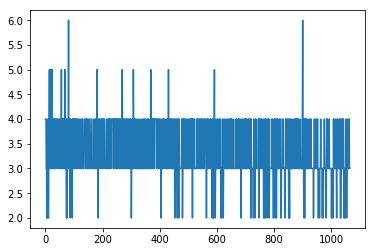

In [21]:
start = time.time()
n_roi = []
for i in range(len(rgb_stack)):
    tmp = morphology.remove_small_objects(predictions_ft[i].numpy() > 0.5, 16)
    _, n = measure.label(tmp, connectivity=1, return_num=True)
    n_roi.append(n)
print("Computation of #ROIs took %.1f s." % (time.time() - start))
print(np.argmax(n_roi), np.argmin(n_roi))
    
plt.figure()
plt.plot(n_roi)
plt.show()

In [46]:
tosave = np.zeros_like(seg_stack)
for i in range(len(rgb_stack)):
    tosave[i] = morphology.remove_small_objects(predictions_ft[i].numpy() > 0.5, 16)

io.imsave("/home/user/talabot/workdir/preds.tif", to_npint(tosave))

## Test drawing for manual annotations
Test drawing by mouse.